# Train Model for Automatic Pancreas Tissue Segmentation

## Import python libraries

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

import random
import shutil

import skimage
from skimage.io import imread
from skimage.transform import resize, rescale
from skimage import img_as_ubyte

from tqdm.auto import tqdm
from collections import defaultdict

import albumentations as A
import segmentation_models as sm

from PIL import Image
from utils import Tiler
import glob
import json

import gc

Image.MAX_IMAGE_PIXELS = 308203636999
IMG_CHANNELS = 3

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


## Define folder structure, and create subset dirs

In [2]:
SOURCE_DATA_DIR = 'data512'  # obtained data from PREPROCESS_DATA notebook
DATA_DIR = 'data512_RANDSPLIT'  # dir where we'll randomly split data into subsets

In [3]:
x_train_dir = os.path.join(DATA_DIR, 'train', 'images')
y_train_dir = os.path.join(DATA_DIR, 'train', 'annotations')

x_valid_dir = os.path.join(DATA_DIR, 'val', 'images')
y_valid_dir = os.path.join(DATA_DIR, 'val', 'annotations')

x_test_dir = os.path.join(DATA_DIR, 'test', 'images')
y_test_dir = os.path.join(DATA_DIR, 'test', 'annotations')

try:
    shutil.rmtree(DATA_DIR)
except:
    pass
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(x_train_dir, exist_ok=True)
os.makedirs(y_train_dir, exist_ok=True)
os.makedirs(x_valid_dir, exist_ok=True)
os.makedirs(y_valid_dir, exist_ok=True)
os.makedirs(x_test_dir, exist_ok=True)
os.makedirs(y_test_dir, exist_ok=True)

## Randomly split data to train, validaton, test subsets
* Training set:  80% - 470 tiles
* Validation set: 15% - 88 tiles
* Testing set: 5% - 30 tiles

In [4]:
train_images = glob.glob(os.path.join(SOURCE_DATA_DIR, "images/*.png"))
choice_list = random.sample(train_images, int(len(train_images)/100 * 20.1))
val_list = random.sample(choice_list, int(len(choice_list)/100 * 75))
test_list = list(set(choice_list) - set(val_list))
train_list = list(set(train_images) - set(choice_list))

In [5]:
for img in train_list:
    shutil.copy2(img, x_train_dir)
    shutil.copy2(img.replace("images", "annotations"), y_train_dir)

for img in val_list:
    shutil.copy2(img, x_valid_dir)
    shutil.copy2(img.replace("images", "annotations"), y_valid_dir)
    
for img in test_list:
    shutil.copy2(img, x_test_dir)
    shutil.copy2(img.replace("images", "annotations"), y_test_dir)

## Count classes distribution
* Count classes distribution by counting pixels in every annotation image
* Can be use for weight rebalancing during training stage


[0.45525256 0.12075247 0.11429147 0.07778401 0.01575305 0.0088628
 0.00662337]
0.7993197278911566
acinar: 45.53%
other: 12.08%
tissue: 11.43%
ducts: 7.78%
vessels: 1.58%
fat: 0.89%
islets: 0.66%


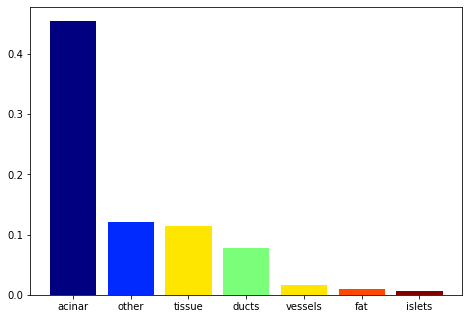

In [6]:
d = defaultdict(int)
x = 0
for f in tqdm(os.listdir(y_train_dir)):
    a = imread(os.path.join(y_train_dir, f))
    a = a[...,0]
    colors, counts = np.unique(a.reshape(-1), 
                           return_counts = True, 
                           axis = 0)
    
    for i, c in enumerate(colors):
        d[c] += counts[i]
        
ratio = np.array(list(d.values())) / (588 * 512*512) # divide by total num of pixels
print(ratio)
print(sum(ratio))

CLASSES = ['acinar', 'other', 'tissue', 'ducts', 'vessels', 'fat', 'islets']
for v in zip(CLASSES, ratio):
    print("{}: {:.2%}".format(v[0], v[1]))
    
fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0,0,1,1])

counts = ratio
ax.bar(CLASSES, counts, color=['#000080', '#002aff', '#ffe600', '#7bff7b', '#ffe600', '#ff4800', '#800000'])
plt.show()

## Helper functions, classes to work with dataset

In [7]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        
        if image.shape[-1] == 7:
            m = image
            ret_matrix = m
            heatmap = np.zeros((m.shape[0], m.shape[1]), dtype=np.uint8)
            max_predmap = np.zeros((m.shape[0], m.shape[1]), dtype=np.float32)

            for i in range(ret_matrix.shape[-1]):
                class_slice = ret_matrix[..., i]
                heatmap[class_slice > max_predmap] = i
                max_predmap = np.where(class_slice > max_predmap, class_slice, max_predmap)

            cmap = plt.get_cmap('jet', 7)
            cmap.set_under('gray')
            plt.imshow(heatmap, cmap=cmap, vmin=0, vmax=6)
            plt.colorbar()
        else:
            plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x  

# classes for data loading and preprocessing
class Dataset:
    """Pancreas Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['acinar', 'other', 'tissue', 'ducts', 'vessels', 'fat', 'islets']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. acinus)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

## Display image with ground truth annotations

In [ ]:
dataset = Dataset(x_train_dir, y_train_dir,
                  classes=['acinar', 'other', 'tissue', 'ducts', 'vessels', 'fat', 'islets'])

image, mask = dataset[8] # get some sample
visualize(
    image=image, 
    Ground_truth_Mask=mask.squeeze(),
)

## On-fly augmentation using Albumenations

In [9]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(),
        A.ShiftScaleRotate(scale_limit=0.2, rotate_limit=0.2, shift_limit=0.2, p=0.3, border_mode=cv2.BORDER_REFLECT_101),
        A.IAAAdditiveGaussianNoise(p=0.4),
        A.OneOf(
            [
                A.CLAHE(clip_limit=2),
                A.RandomGamma(),
                A.RandomBrightnessContrast(),
            ],
            p=0.3,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=0.2),
                A.Blur(blur_limit=3, p=0.2),
                A.MotionBlur(blur_limit=3, p=0.2),
            ],
            p=0.3,
        ),
        A.HueSaturationValue(p=0.4),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    
    # not needed now, because all our tiles are 512x512
    test_transform = [
        #A.PadIfNeeded(min_height=512, min_width=512, always_apply=True, border_mode=0),
        #A.RandomCrop(height=512, width=512, always_apply=True),
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

## Model configuration

In [ ]:
BACKBONE = 'resnet34' # can be resnet50, vgg, and many other
BATCH_SIZE = 2  # if have GPU with big memory can encrease to train faster
CLASSES = ['acinar', 'other', 'tissue', 'ducts', 'vessels', 'fat', 'islets']
LR = 0.0001  # learning rate
EPOCHS = 20  # number of epochs after which stop the training

# transform out 7 class mask to backbone input
preprocess_input = sm.get_preprocessing(BACKBONE)  

# define network parameters
n_classes = len(CLASSES) 
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
sm.set_framework('keras') # if training fails try setting: sm.set_framework('tf.keras')
model = sm.Unet(BACKBONE, encoder_weights=None, classes=n_classes, activation=activation)

## Weight penalties for classes (calculated above)

In [12]:
weights = np.array([1.729094,
                   7.06125925,
                   10.51857401,
                   6.88608812,
                   49.86985982,
                   93.6103983,
                   110.86937782])

# shift weight more to their common mean
def f(x, mean, ratio=0.2):
    return x + (mean - x) * ratio

mean = np.mean(weights)
shifted = [f(val, mean) for val in weights]

weights_norm = shifted / sum(shifted)
print("Normalized weights to give sum of 1.0:", weights_norm)

Normalized weights to give sum of 1.0: [0.03350211 0.04870729 0.05856615 0.04820777 0.17078012 0.29551046
 0.3447261 ]


## Define optimizers, metrics and losses

In [ ]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss(class_weights=weights_norm)
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

## Create datasets/dataloaders with on-fly augmentators

In [14]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation= get_training_augmentation(), #get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for test images
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)
test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 512, 512, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 512, 512, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./models/weights_{epoch:03d}.h5',
                                    save_weights_only=True,
                                    save_best_only=False,
                                    monitor='val_f1_score',
                                    mode='auto'),
    keras.callbacks.ReduceLROnPlateau(),
]

## Display sample with on-fly augmentation

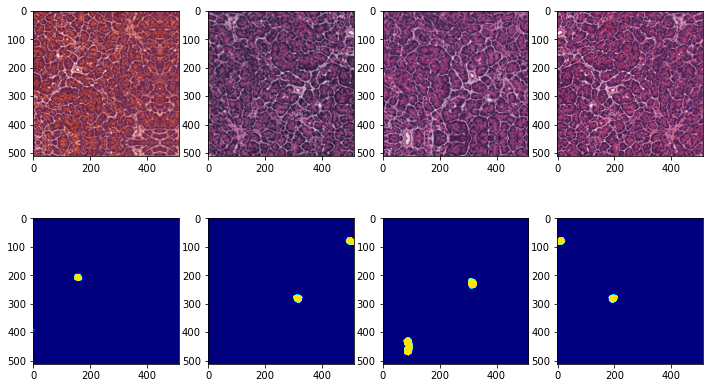

In [15]:
n_row = 2
n_col = 4
_, axs = plt.subplots(n_row, n_col, figsize=(12, 7))

cmap = plt.get_cmap('jet', 7)
cmap.set_under('gray')

sample_id = 20

for i in range(4):
    sample = train_dataset[sample_id]
    axs[0,i].imshow(sample[0])
    axs[1,i].imshow((np.argmax(sample[1], axis = 2)), cmap=cmap, vmin=0, vmax=6)

## Run training, show plots after finished

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
235/235 [==============================] - 61s 260ms/step - loss: 1.0294 - iou_score: 0.1105 - f1-score: 0.1287 - val_loss: 1.0064 - val_iou_score: 0.5094 - val_f1-score: 0.5353
Epoch 2/20
235/235 [==============================] - 46s 196ms/step - loss: 1.0145 - iou_score: 0.2445 - f1-score: 0.2776 - val_loss: 1.0461 - val_iou_score: 0.3694 - val_f1-score: 0.3963
Epoch 3/20
235/235 [==============================] - 45s 193ms/step - loss: 1.0108 - iou_score: 0.2989 - f1-score: 0.3342 - val_loss: 1.0412 - val_iou_score: 0.4949 - val_f1-score: 0.5225
Epoch 4/20
235/235 [==============================] - 46s 195ms/step - loss: 1.0087 - iou_score: 0.2922 - f1-score: 0.3272 - val_loss: 0.9998 - val_iou_score: 0.5155 - val_f1-score: 0.5418
Epoch 5/20
235/235 [==============================] - 45s 193ms/step - loss: 1.0057 - iou_score: 0.2448 - f1-score: 0.2859 - val_loss: 1.0226 - val_

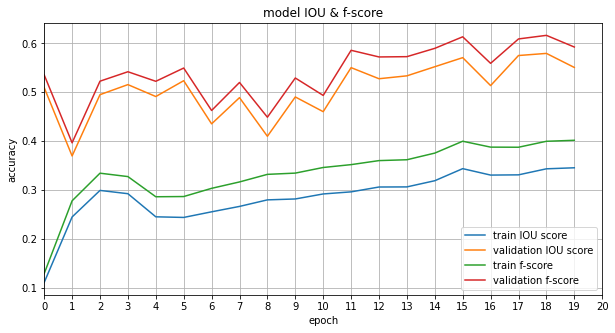

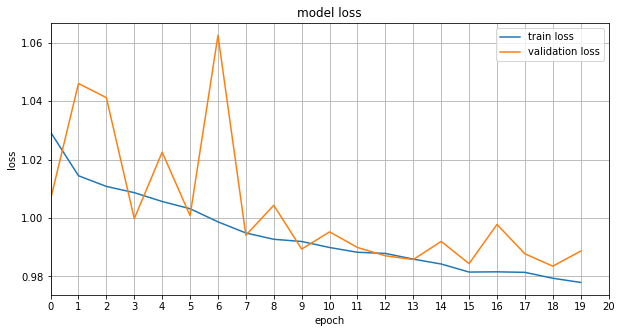

In [16]:
TRAIN = True  # Set to False, if want to Kernel Restart-Run All but skip training

if TRAIN:
    # train model
    history = model.fit_generator(
        train_dataloader, 
        steps_per_epoch=len(train_dataloader), 
        epochs=EPOCHS, 
        callbacks=callbacks, 
        validation_data=valid_dataloader, 
        validation_steps=len(valid_dataloader),
    )
    
    plt.figure(figsize=(10,5))
    plt.plot(history.history['iou_score'], label='train IOU score')
    plt.plot(history.history['val_iou_score'], label='validation IOU score')
    plt.plot(history.history['f1-score'], label='train f-score')
    plt.plot(history.history['val_f1-score'], label='validation f-score')
    plt.title('model IOU & f-score')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='lower right')
    plt.grid()
    plt.xticks(np.arange(0, 20+1, 1.0))
    plt.xlim(0, 20)
    #plt.savefig(os.path.join(OUT_FOLDER, 'train-score.pdf'), format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='upper right')
    plt.grid()
    plt.xticks(np.arange(0, 20+1, 1.0))
    plt.xlim(0, 20)
    #plt.savefig(os.path.join(OUT_FOLDER, 'train-loss.pdf'), format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

## Load best weights - can inspect from the plot

In [55]:
#model.load_weights('models/weights_016.h5')
model.load_weights('models/best_model.h5')

## Evaluate model on Test Data

In [54]:
scores = model.evaluate_generator(test_dataloader)

# Note - metrics can change if we re-generate (test) subsets
print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.98029
mean iou_score: 0.5353
mean f1-score: 0.58334


## Display some segmentations and compare with Ground Truth

1/1 [==============================] - 0s 44ms/step


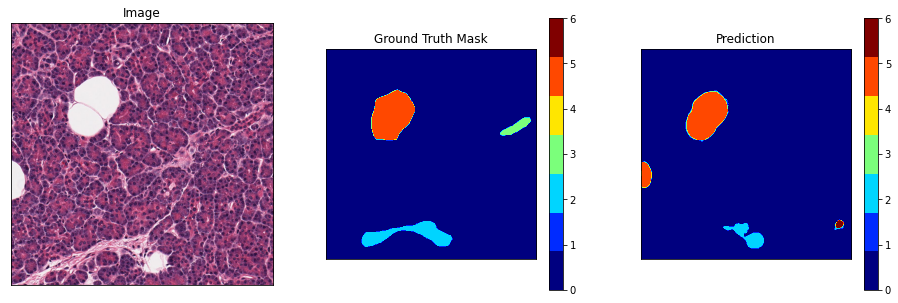

1/1 [==============================] - 0s 35ms/step


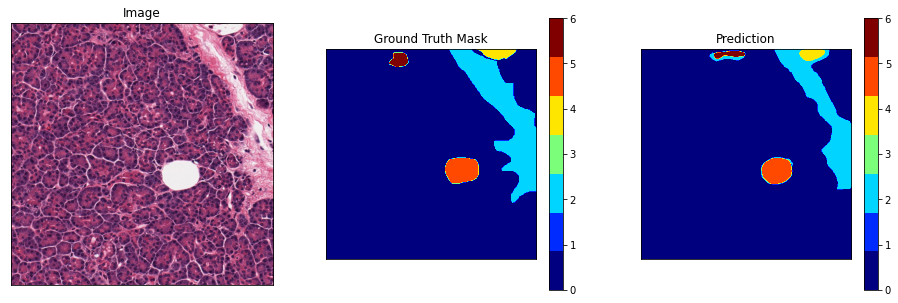

1/1 [==============================] - 0s 35ms/step


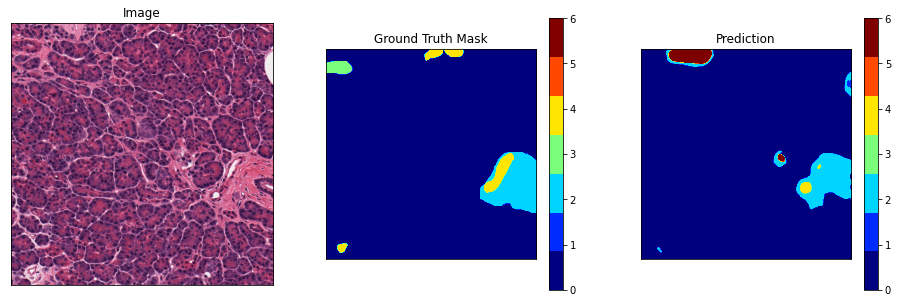

1/1 [==============================] - 0s 35ms/step


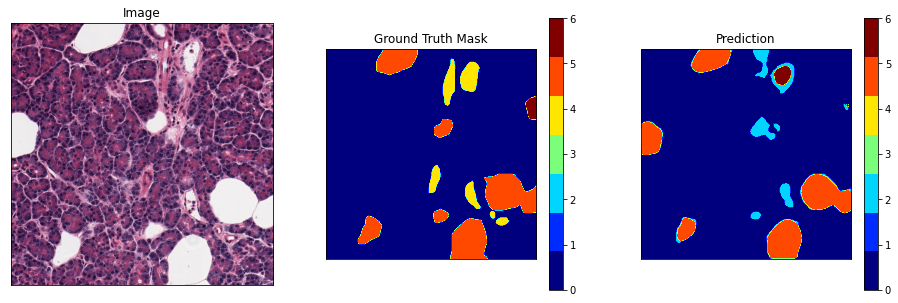

1/1 [==============================] - 0s 36ms/step


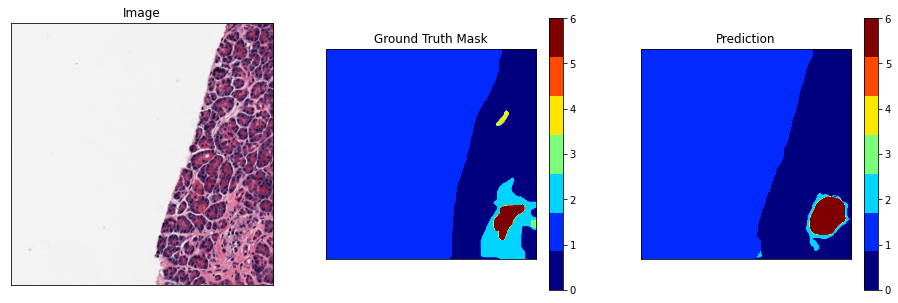

1/1 [==============================] - 0s 36ms/step


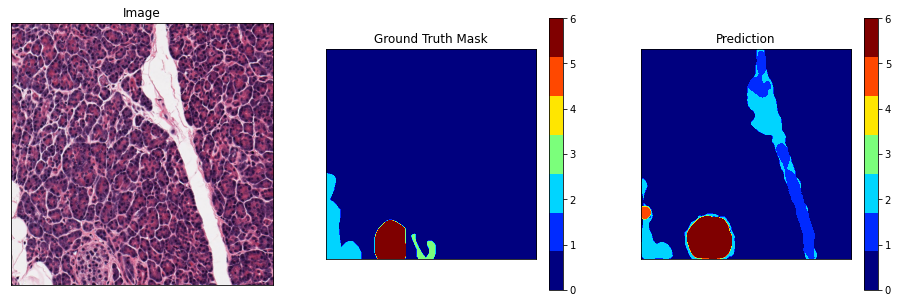

In [57]:
for i in range(4, 10):
    image, mask = test_dataset[i]
    predict = model.predict([np.expand_dims(image, 0)], batch_size=1, verbose=1)

    visualize(
        image=image, 
        Ground_truth_Mask=mask.squeeze(),
        prediction=predict.squeeze()
    )